# **Detecting the Type of Tor Traffic**


---


  
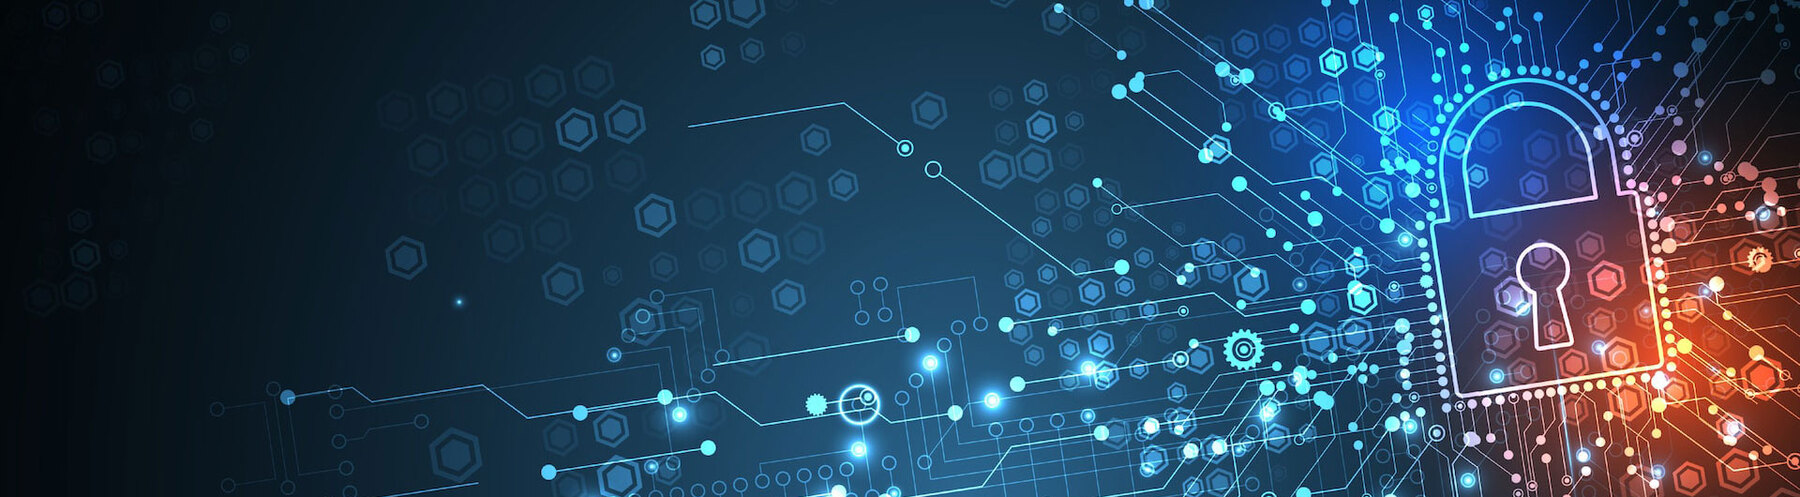

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

# Introduction

The **Tor (Onion Router) network** provides a safe place for Internet users to exchange data without revealing their identity and obfuscates the traffic which makes it difficult for potential observers or eavesdroppers to trace the user's online activities. While Tor software has enhanced online privacy for users, it has also paved a way for the criminals to engage in illicit activities while remaining anonymous, thereby posing significant challenges for law enforcement agencies in their efforts to trace and apprehend wrongdoers. Thus, **classifying Tor traffic from non-Tor traffic is critical to trace the Darknet users**. In addition, it can be effective in intrusion detection systems (IDS) and intrusion prevention systems (IPS) which rely on knowledge of normal network behavior to detect and prevent such attacks.

#### **Dataset Overview**
The UNB-CIC Tor Network Traffic Dataset has been amassed by the Information Security Center of Excellence (ISCX) at the University of New Brunswick in Canada in 2016. This dataset includes regular and Tor traffic recorded over a two-week timeframe and extracted from diverse network interfaces and devices, including laptops, smartphones, wired and wireless connections, and servers.

Our [dataset](https://www.unb.ca/cic/datasets/tor.html) has `8044` instances containig `28` input features with `2` different target labels, so with these labels we aim to implement two Scenarios, first for detecting benign and Darknet traffic and second for classifing the type of the traffic.

The following table briefly describes each feature of the dataset :-

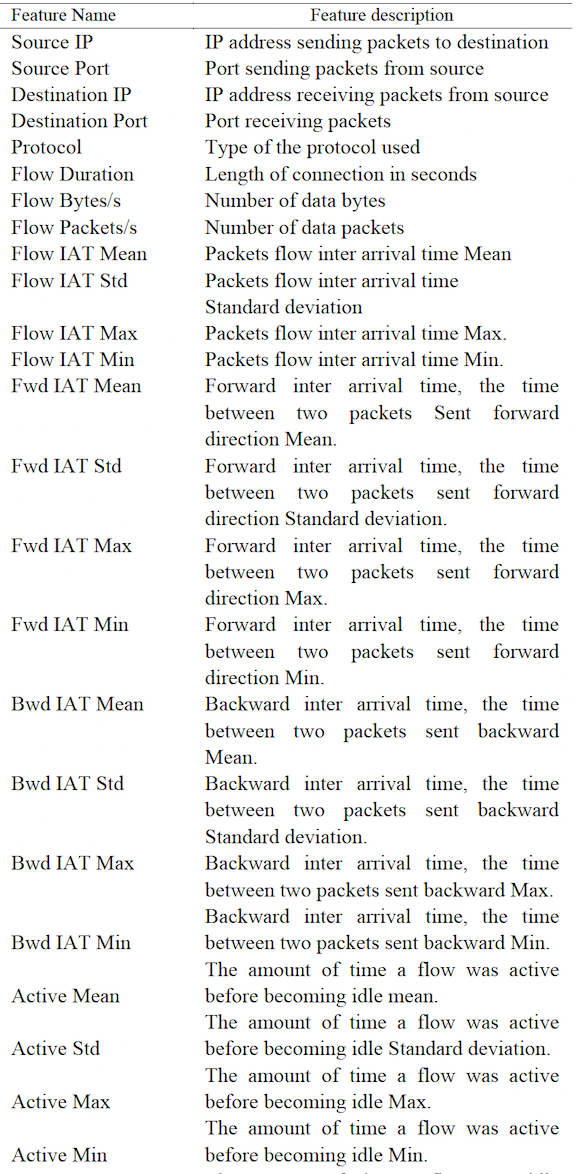

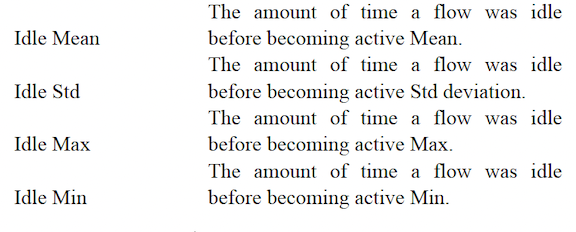

# In this file we are working on Scenario2
---
*Multiclass classification*

## Importing dataset

In [4]:
dataset = pd.read_csv("TimeBasedFeatures-10s-Layer2.csv")
dataset.shape

(8044, 29)

## Features names

In [5]:
# Get the row using iloc and then retrieve the column names
column_names = dataset.columns
targets = ['Label', 'Label.1']
feature_names = [col for col in column_names if col not in targets]

print("Feature names:")
print(feature_names)
counts = len(feature_names)
print(f"\nThey are: {counts} features")

Feature names:
['Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Active Mean', ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max', ' Idle Min', 'label']

They are: 29 features


## Print all unique labels

In [6]:
labels = dataset.iloc[:,-1].unique()


print(f"Scenario2 labels:\n{labels}\n")

Scenario2 labels:
['AUDIO' 'BROWSING' 'CHAT' 'FILE-TRANSFER' 'MAIL' 'P2P' 'VIDEO' 'VOIP']



## Print count of each unique label
---
Some labels have been repeated with both lower and upper case that we will  handle it in 'converting labels' section.

In [7]:
Scenario2_label_counts = dataset.iloc[:, -1].value_counts()

print(f"Seanrio2 label counts:\n{Scenario2_label_counts}")

Seanrio2 label counts:
label
VOIP             2291
BROWSING         1604
P2P              1085
VIDEO             874
FILE-TRANSFER     864
AUDIO             721
CHAT              323
MAIL              282
Name: count, dtype: int64


# Defining preprocessing functions

## Checking if there are any missing values in the dataset

In [10]:
def check_missing(data):
    missing_flag = False
    for column in data.columns:
        missing_count = data[column].isnull().sum()
        if missing_count > 0:
            print(f"Feature '{column}' has {missing_count} missing values.")
            missing_flag = True
    
    if not missing_flag:
        print("No missing data in the whole dataset.")

In [11]:
# checking missing data in the dataset
check_missing(dataset)

No missing data in the whole dataset.


## Checking if we have categorical features

In [12]:
categorical_columns = dataset.select_dtypes(exclude=['float64', 'int64']).columns
if len(categorical_columns) > 0:
    print("The dataset has categorical columns.")
    print("Categorical columns:", list(categorical_columns))
else:
    print("The dataset does not have any categorical columns.")

The dataset has categorical columns.
Categorical columns: ['Source IP', ' Destination IP', 'label']


## Converting categorical features

In [21]:
def cat_conv(data):
    data.loc[:,'Source IP'] = data.loc[:,'Source IP'].apply(hash).astype('float64')
    data.loc[:,' Destination IP'] = data.loc[:,' Destination IP'].apply(hash).astype('float64')

    return data

In [22]:
# Converting categorical features to numeric ones in the dataset
clean_data = cat_conv(dataset)

## Creating X and y
---
Dividing data to features(X) and labels(y) 

In [29]:
from sklearn.model_selection import train_test_split

def X_y_creation(dataset):

    X = dataset.iloc[:, :-1]
    y = dataset.iloc[:, -1]
    
    return X, y

In [30]:
# X, y for Scenario2
X, y_multi = X_y_creation(clean_data)

## Dropping infinite values in the entire DataFrame

In [31]:
def infinite_value_drop(X, y):
    # Replacing infinite features with NaN
    X_inf_dropped = X.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    # Droping NaN features
    y_inf_dropped = y[X.index.isin(X_inf_dropped.index)]
    return X_inf_dropped, y_inf_dropped

In [32]:
# Dropping infinite values for Scenario2
X_inf_dropped, y_multi_inf_dropped = infinite_value_drop(X, y_multi)

## Converting labels for Scenario2
---

Converting all labels from nominal to numeric ones using Label Encoding in Scenario2.

In [42]:
from sklearn.preprocessing import LabelEncoder
def converting_multi(y):
    label_encoder = LabelEncoder()
    y_numeric_multi = label_encoder.fit_transform(y)
    y_numeric_multi = pd.Series(y_numeric_multi)

    return y_numeric_multi

In [45]:
# Converting y_multi to numeric values
y_multi_converted = converting_multi(y_multi_inf_dropped)
print(y_multi_converted)
print(type(y_multi_converted))
print(y_multi_converted.unique())
print(y_multi_converted.shape)


0       0
1       0
2       0
3       0
4       0
       ..
8039    2
8040    2
8041    2
8042    2
8043    2
Length: 8044, dtype: int32
<class 'pandas.core.series.Series'>
[0 1 2 3 4 5 6 7]
(8044,)


## Standardizing features

In [46]:
def standardization(X_train, X_test):
    from sklearn.preprocessing import StandardScaler

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

<!-- ### Finding Correlations -->

## Feature selection

In [76]:
def feature_selection(X, data, X_train, y_train, X_test):
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.datasets import load_iris
    from sklearn.feature_selection import SelectFromModel

    clf = ExtraTreesClassifier(n_estimators=50)
    clf.fit(X_train, y_train)
    model = SelectFromModel(clf, prefit=True)
    X_train = model.transform(X_train)
    X_test = model.transform(X_test)
    selected_feature_indices = model.get_support(indices=True)
    selected_features = [feature_names[i] for i in selected_feature_indices]
    return X_train, X_test, selected_features

## Checking if data is imbalanced

In [48]:
def check_imbalancing(y):
  class_counts = y.value_counts()

  plt.figure(figsize=(8, 6))
  class_counts.plot(kind='bar')
  plt.title("Class Distribution")
  plt.xlabel("Class")
  plt.ylabel("Count")
  # Rotate x-axis labels to be horizontal
  plt.xticks(rotation=0)
  plt.show()

  imbalance_ratio = class_counts.min() / class_counts.max()

  print("Class Counts:")
  print(class_counts)
  print("Imbalance Ratio: {:.2f}".format(imbalance_ratio))

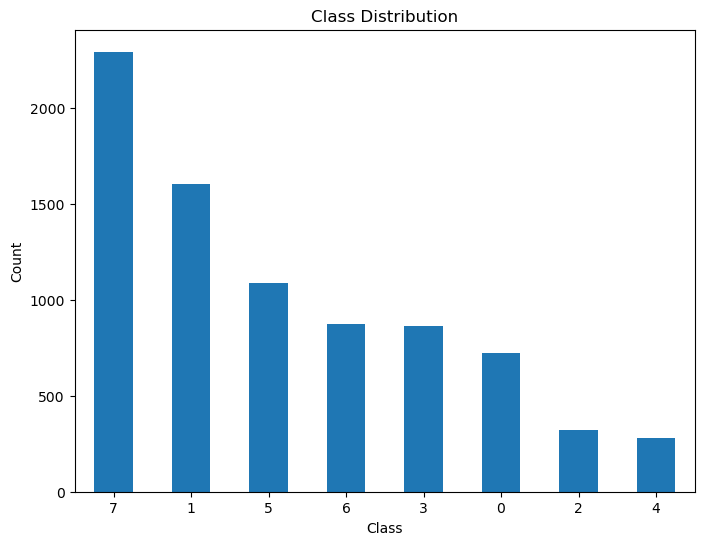

Class Counts:
7    2291
1    1604
5    1085
6     874
3     864
0     721
2     323
4     282
Name: count, dtype: int64
Imbalance Ratio: 0.12


In [50]:
# Checking if data is imbalanced in Scenario2
check_imbalancing(y_multi_converted)

## Balancing with SMOTE

In [51]:
def smote(X_train, y_train):
    from collections import Counter
    from sklearn.datasets import make_classification
    from imblearn.over_sampling import SMOTE
    
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    return X_train, y_train

## Hyperparameter Tuning with Grid search

In [52]:
def HyperP_tuning(model, HyperParameters, X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    
    grid_search = GridSearchCV(estimator=model, param_grid=HyperParameters, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    model = grid_search.best_estimator_
    return model, best_params

# main function
---

It will do all trainig, and prediction in a single function called main. This approach makes us able to be more efficient and do the DRY principle which stands for "Don't Repeat Yourself!"

In [109]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def main(X_train, X_test, y_train, y_test, model, feature_names,
         standardization, feature_selection, balancing, HyperParameters, HyperP_tuning):
    
    X_train, X_test = standardization(X_train, X_test)
    X_train, X_test, selected_features = feature_selection(X, dataset, X_train, y_train, X_test)
    X_train, y_train = balancing(X_train, y_train)
    model, best_params = HyperP_tuning(model, HyperParameters, X_train, y_train) # Trainig
    y_pred = model.predict(X_test) # Predicting
    f1_score_weighted= f1_score(y_test, y_pred, average='weighted')
    precision_weighted= precision_score(y_test, y_pred, average='weighted')
    recall_weighted= recall_score(y_test, y_pred, average='weighted')
    return model, selected_features, best_params, f1_score_weighted, precision_weighted, recall_weighted, y_pred

## Stratified cross-validation
---
Using Stratified cross-validation for splitting dataset to train set and test set with 5 splits, instead of doing a simple splitting.

# main_with_crossval
---
We call main function inide of main_with_crossvall function for training and testing model on each mini train set and test set created from Stratified cross-validation.

In [110]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def main_with_crossval(dataset,
    cat_conv,
    main_func,
    model,
    X_y_creation,infinite_value_drop, converting_func,
    HyperParameters):
    clean_data = cat_conv(dataset)
    X, y = X_y_creation(clean_data)
    X, y = infinite_value_drop(X, y)
    y = converting_func(y)
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    f1_scores = []
    precisions = []
    recalls = []
    X = X.values
    y = y.values
    predictions = []
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model, selected_features, best_params, f1_score_weighted, precision_weighted, recall_weighted, y_pred = main(X_train, X_test, y_train, y_test, model,
                                                                                                  feature_names=feature_names,
                                                                                                  standardization=standardization,
                                                                                                  feature_selection=feature_selection,
                                                                                                  balancing=smote,
                                                                                                  HyperParameters= HyperParameters,
                                                                                                  HyperP_tuning = HyperP_tuning)
        predictions = y_pred
        f1_scores.append(f1_score_weighted)
        precisions.append(precision_weighted)
        recalls.append(recall_weighted)
        
    f1_avg = np.mean(f1_scores)
    precision_avg = np.mean(precisions)
    recall_avg = np.mean(recalls)

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    return f1_avg, precision_avg, recall_avg, model, selected_features, best_params

## RandomForest Classifier

In [79]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion = 'entropy', random_state = 0)

## Decision Trees Classifier

In [57]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 0)

## K-Nearest Neighbors Classifier

In [58]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

## Logistic Regression Classifier

In [59]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(random_state = 0)

## XGBoost Classifier

In [60]:
from xgboost import XGBClassifier 
xgb = XGBClassifier()

# Scenario 2: Type of traffic Detection


---

**Multiclass classification problem**

Labels that show the types of traffic: `browsing`, `chat`, `email`, `File-transfer`, `P2P`, `video-streaming`, `audio-streaming`, `voip` which we have converted to numbers from 0 to 7.

## RandomForest_Scenario2

In [111]:
rf_parameters =  {
    'n_estimators': [10,100, 200],
    'max_depth': [20,30, None],
    'min_samples_split': [2,10,5] 
}

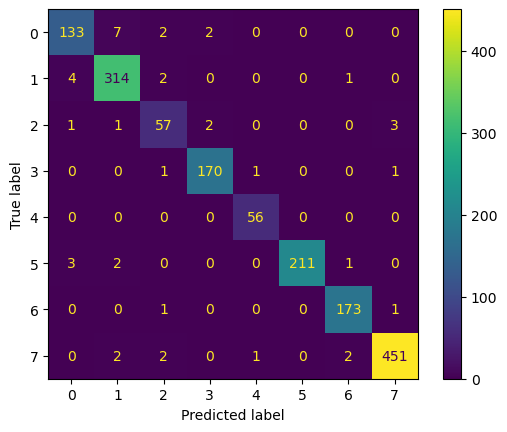

Multi F1 Average (rf): 0.9743700499451895
Multi Precision Average (rf): 0.9747007420023273
Multi Recall Average (rf): 0.974266408788871
Selected Features: ['Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Max', 'Fwd IAT Mean', ' Fwd IAT Max', 'Bwd IAT Mean', ' Bwd IAT Max']
Multi best Parameters for rf: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [112]:
multi_f1_avg_rf, multi_precision_avg_rf,multi_recall_avg_rf,multi_model_rf, selected_features,multi_best_params_rf = main_with_crossval(dataset = dataset,
                                                 model = rf,
                                                 converting_func = converting_multi,
                                                 cat_conv=cat_conv,
                                                 main_func = main,
                                                 X_y_creation=X_y_creation,
                                                 infinite_value_drop=infinite_value_drop,
                                                 HyperParameters = rf_parameters)
                                                 

print(f"Multi F1 Average (rf): {multi_f1_avg_rf}")
print(f"Multi Precision Average (rf): {multi_precision_avg_rf}")
print(f"Multi Recall Average (rf): {multi_recall_avg_rf}")
print(f"Selected Features: {selected_features}")
print(f"Multi best Parameters for rf: {multi_best_params_rf}")

## Decision Trees_Scenario2

In [113]:
dt_parameters =  {
    'max_depth': [None,2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini","entropy"] 
}

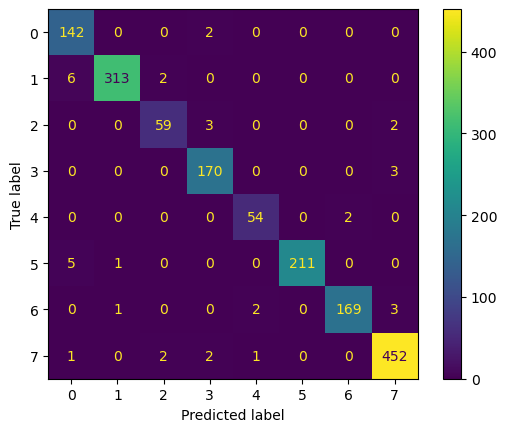

Multi F1 Average (dt): 0.9807173778033651
Multi Precision Average (dt): 0.9811185904283244
Multi Recall Average (dt): 0.9806061365020764
Selected Features: ['Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Flow Duration', ' Flow Bytes/s', ' Flow IAT Max', 'Fwd IAT Mean', ' Fwd IAT Max', ' Bwd IAT Max']
Multi best Parameters for dt: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5}


In [114]:
multi_f1_avg_dt, multi_precision_avg_dt,multi_recall_avg_dt,multi_model_dt, selected_features, multi_best_params_dt = main_with_crossval(dataset = dataset,
                                                 model = dt,
                                                 converting_func = converting_multi,
                                                 cat_conv=cat_conv,
                                                 main_func = main,
                                                 X_y_creation=X_y_creation,
                                                 infinite_value_drop=infinite_value_drop,
                                                 HyperParameters = dt_parameters)
                                                

print(f"Multi F1 Average (dt): {multi_f1_avg_dt}")
print(f"Multi Precision Average (dt): {multi_precision_avg_dt}")
print(f"Multi Recall Average (dt): {multi_recall_avg_dt}")
print(f"Selected Features: {selected_features}")
print(f"Multi best Parameters for dt: {multi_best_params_dt}")

## XGBoost_Scenario2

In [115]:
xgb_parameters ={
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9],
    'tree_method': ['auto', 'exact', 'approx', 'hist'], 
    'enable_categorical':[True, False], 
    'booster':['gbtree', 'gblinear', 'dart'], 
    'objective':['reg:squarederror', 'multi:softmax', 'binary:logistic'], 
    'verbosity':[0,1,2],
    'learning_rate':[0.01, 0.1, 0.2], 
    'subsample':[0.8, 1.0, 0.9] 
}

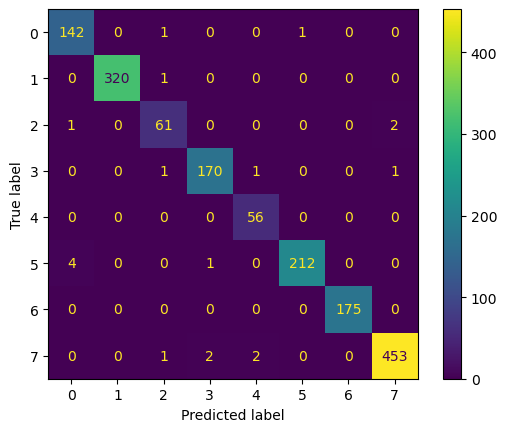

Multi F1 Average (xgb): 0.9893413940794609
Multi Precision Average (xgb): 0.9895114181369357
Multi Recall Average (xgb): 0.9893086617873962
Selected Features: ['Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Max', ' Fwd IAT Max', 'Bwd IAT Mean', ' Bwd IAT Max']
Multi best Parameters for xgb: {'booster': 'gbtree', 'enable_categorical': True, 'gamma': 0.2, 'learning_rate': 0.1, 'objective': 'reg:squarederror', 'subsample': 0.8, 'tree_method': 'hist', 'verbosity': 0}


In [116]:
multi_f1_avg_xgb, multi_precision_avg_xgb,multi_recall_avg_xgb, multi_model_xgb, selected_features, multi_best_params_xgb = main_with_crossval(dataset = dataset,
                                                 model = xgb,
                                                 converting_func = converting_multi,
                                                 cat_conv=cat_conv,
                                                 main_func = main,
                                                 X_y_creation=X_y_creation,
                                                 infinite_value_drop=infinite_value_drop,
                                                 HyperParameters = xgb_parameters)
                                                 

print(f"Multi F1 Average (xgb): {multi_f1_avg_xgb}")
print(f"Multi Precision Average (xgb): {multi_precision_avg_xgb}")
print(f"Multi Recall Average (xgb): {multi_recall_avg_xgb}")
print(f"Selected Features: {selected_features}")
print(f"Multi best Parameters for xgb: {multi_best_params_xgb}")

## VotingClassifier
---
Ensumbling Random Forest and XGBoost models using VotingClassifier

## VotingClassifier

In [119]:
from sklearn.ensemble import VotingClassifier
# Create a VotingClassifier
vote = VotingClassifier(estimators=[('rf', multi_model_rf), ('xgb', multi_model_xgb)], voting='soft')
vote_parameters = {} 

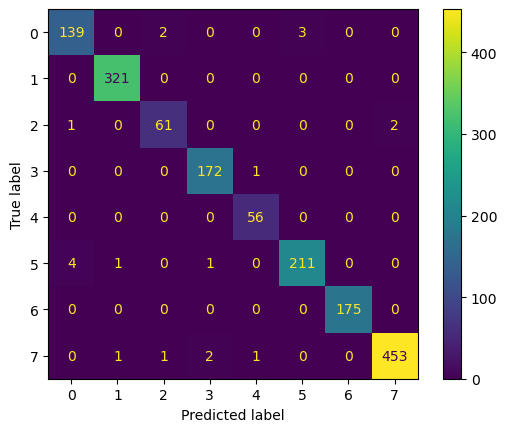

Multi F1 Average (vote): 0.9881206665895798
Multi Precision Average (vote): 0.9883195053679069
Multi Recall Average (vote): 0.9880655764063461
Selected Features: ['Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Flow Duration', ' Flow Bytes/s', ' Flow IAT Max', ' Fwd IAT Max', ' Bwd IAT Max']
Multi best Parameters for vote: {}


In [120]:
multi_f1_avg_vote, multi_precision_avg_vote,multi_recall_avg_vote,multi_model_vote, selected_features, multi_best_params_vote = main_with_crossval(dataset = dataset,
                                                 model = vote,
                                                 converting_func = converting_multi,
                                                 cat_conv=cat_conv,
                                                 main_func = main,
                                                 X_y_creation=X_y_creation,
                                                 infinite_value_drop=infinite_value_drop,
                                                 HyperParameters = vote_parameters)
                                                 

print(f"Multi F1 Average (vote): {multi_f1_avg_vote}")
print(f"Multi Precision Average (vote): {multi_precision_avg_vote}")
print(f"Multi Recall Average (vote): {multi_recall_avg_vote}")
print(f"Selected Features: {selected_features}")
print(f"Multi best Parameters for vote: {multi_best_params_vote}")

## Comparing models_Scenario2

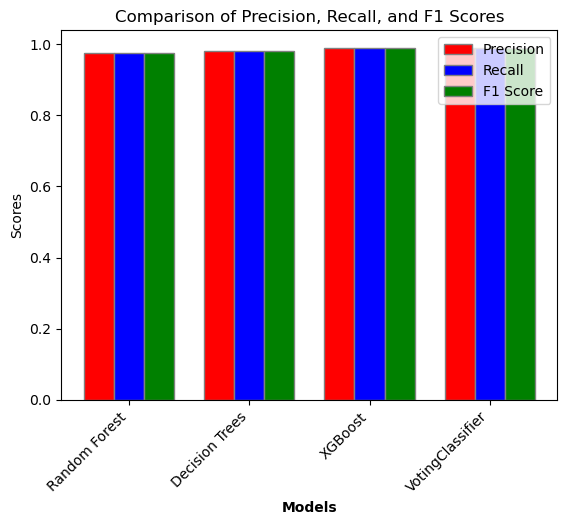

In [124]:
f1_scores = [multi_f1_avg_rf, multi_f1_avg_dt, multi_f1_avg_xgb, multi_f1_avg_vote]
precision_scores = [multi_precision_avg_rf, multi_precision_avg_dt, multi_precision_avg_xgb, multi_precision_avg_vote]
recall_scores = [multi_recall_avg_rf, multi_recall_avg_dt, multi_recall_avg_xgb, multi_recall_avg_vote]
labels = ['Random Forest', 'Decision Trees', 'XGBoost', 'VotingClassifier']

# Bar width
bar_width = 0.25

# Set up positions for the bars
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the grouped bar plot
plt.bar(r1, precision_scores, color='red', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall_scores, color='blue', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_scores, color='green', width=bar_width, edgecolor='grey', label='F1 Score')

# Adding labels and title
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(labels))], labels)
plt.ylabel('Scores')
plt.title('Comparison of Precision, Recall, and F1 Scores')
plt.xticks(rotation=45, ha='right') 
plt.legend()

# Display the plot
plt.show()

# Best features
---

for both Scenarios they are the same as we are using one dataset and the same feature selection method for both Scenarios.

In [125]:
print(selected_features)
print(f"\nThere are {len(selected_features)} features selected.")

['Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Flow Duration', ' Flow Bytes/s', ' Flow IAT Max', ' Fwd IAT Max', ' Bwd IAT Max']

There are 9 features selected.
